# Machine Learning Notebook

This notebook is the second installment of the French Motor Insurance Coding Challenge. In this section, the primary focus is on developing a regression model to predict the ClaimAmount/Exposure variable, as defined in the previous notebook.

The notebook is organized as follows:

1.	Manual Modeling
-	Linear Models
	-	Linear Regression
	-	Ridge Regression with Grid Search
	-	Polynomial Regression
-	Non-Linear Models
	-	Random Forest Regression
	-	XGBoost
	-	Neural Networks
2.	Automatic Modeling
	-	Utilizing PyCaret to identify the optimal model for the given dataset
3.	Discussion


---

# Importing Libraries

In [20]:
#base
import pandas as pd
import numpy as np
import sys

#visualisations
import matplotlib.pyplot as plt
import seaborn as sns


#ml
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler


from sklearn.metrics import mean_squared_error, r2_score,  make_scorer, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import TweedieRegressor
from sklearn.feature_selection import SelectKBest, f_regression


#automatic modeling
import pycaret
from pycaret.regression import *

import optuna



#neural networks
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#tracking
import mlflow


#visualisations
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append("..")

#helper functions
from helpers.models import *
from helpers.helper_functions import *

mlflow.set_tracking_uri("../mlruns")



---
# Loading Processed Data and Fixing Data Formats

In [21]:
data = pd.read_csv('../data/cleaned_data.csv')

display(data.head())

display(data.dtypes)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,...,BonusMalus_Region_other_Avg,VehPower_binned,Exposure_binary,ClaimFrequency,DrivAge_binned,DriverExperience,VehAge_binned,RiskScore,BonusMalusClass,Density_log
0,139,1,0.75,F,7,1,61,50,12,R,...,67.413297,3,Less than 1 Year,1.333333,56-65,43,0-2,1.220000,Bonus,10.203592
1,190,1,0.14,B,12,5,50,60,12,D,...,64.188606,5,Less than 1 Year,7.142857,46-55,32,5-7,0.833333,Bonus,4.025352
2,414,1,0.14,E,4,0,36,85,12,R,...,67.413297,1,Less than 1 Year,7.142857,36-45,18,0-2,0.423529,Bonus,8.474703
3,424,2,0.62,F,10,0,51,100,12,R,...,67.413297,4,Less than 1 Year,3.225806,46-55,33,0-2,0.510000,Malus,10.203592
4,424,2,0.62,F,10,0,51,100,12,R,...,67.413297,4,Less than 1 Year,3.225806,46-55,33,0-2,0.510000,Malus,10.203592


IDpol                            int64
ClaimNb                          int64
Exposure                       float64
Area                            object
VehPower                         int64
VehAge                           int64
DrivAge                          int64
BonusMalus                       int64
VehBrand                         int64
VehGas                          object
Density                          int64
Region                           int64
Target                         float64
Exposure_Area_Avg              float64
VehPower_Area_Avg              float64
DrivAge_Area_Avg               float64
BonusMalus_Area_Avg            float64
VehBrand_Frequency              object
VehBrand_Other                  object
Region_Frequency                object
Region_other                    object
Exposure_Region_Avg            float64
VehPower_Region_Avg            float64
DrivAge_Region_Avg             float64
BonusMalus_Region_Avg          float64
Exposure_Region_other_Avg

In [22]:
#int64 columns
int64_cols = data.select_dtypes(include = ['int64']).columns

#categorical columns
cat_cols = data.select_dtypes(include = ['category', 'object']).columns


for col in int64_cols:
    data[col] = data[col].astype('int32')

for col in cat_cols:
    data[col] = data[col].astype('category')

---
# Manual Modeling


In this section, I will explore various manual modeling approaches, beginning with basic linear regressions and progressing to more complex non-linear models. The aim is to evaluate the performance of different models and determine if a well-chosen model and thoughtful feature engineering can mitigate the challenges posed by the low correlations identified in the exploratory_data_analysis.ipynb. While it’s tempting to believe that a good model alone can overcome such challenges, it’s important to recognize that this is often not the case (spoiler alert: it usually doesn’t work that way).


---
## Linear Models

In this part, I see how linear model would perform on our dataframe. I already assumed that there might have been multicollinearity. 


#### Preparing the Data

In [23]:
data.set_index('IDpol', inplace=True)
y_log = np.log(data['Target'])


columns_to_drop = ['Target']
data_features = data.drop(columns_to_drop, axis=1)

The data needs to be scaled because it contains features with varying ranges of values. Without scaling, linear regression may not perform well, as it assumes that all features contribute equally to the prediction. Unscaled data can lead to biased coefficients, where features with larger ranges dominate the model’s behavior.

To address this, I use the StandardScaler, which standardizes the data by subtracting the mean and dividing by the standard deviation. This process transforms the data to have a mean of 0 and a standard deviation of 1, ensuring that each feature contributes proportionally to the model. This is particularly important in linear regression, where differences in feature scales can significantly impact the model’s performance.


In [24]:

# Splitting into test and train
X_train, X_test, y_train, y_test = train_test_split(data_features, y_log, test_size=0.2, random_state=42)

# Identify categorical and numerical columns
categorical_columns = data_features.select_dtypes(include=['category', 'object']).columns
numerical_columns = data_features.select_dtypes(include=['int', 'float']).columns

#apply scaler to numerical columns
scaler = StandardScaler()
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

X_train_processed[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_processed[numerical_columns] = scaler.transform(X_test[numerical_columns])

#apply one hot encoding to categorical columns
X_train_processed = pd.get_dummies(X_train_processed, columns=categorical_columns)
X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_columns)


print(X_train_processed.shape)
print(X_test_processed.shape)

(20967, 76)
(5242, 76)


### Linear Regression

In [57]:
#linear regression
mlflow.set_experiment("Manual Modeling")

train_linear_regression(X_train_processed, X_test_processed, y_train, y_test, 'full_data_scaled', run_name = 'Linear Regression All Data')

2024/08/14 02:22:14 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


Linear Regression Results:
MSE: 1.33729693732237
R Squared: 0.3334913774952022
Exposure: -0.9360098872230347
VehAge: -0.05495989660387662
BonusMalus: 0.1313306143261705
VehBrand: 0.03607022283304401
Region: 0.012761989568593556
Exposure_Area_Avg: 2318501835705.1675
VehPower_Area_Avg: -54725894129.84512
DrivAge_Area_Avg: 4402322159323.693
BonusMalus_Area_Avg: 2176980178597.942
Exposure_Region_Avg: 0.305005430283799
VehPower_Region_Avg: -0.028529627818705876
DrivAge_Region_Avg: 0.011332432088057634
VehPower_Region_other_Avg: 5651728887457.742
DrivAge_Region_other_Avg: -2975236561272.7803
BonusMalus_Region_other_Avg: -3193072504677.6064
VehPower_binned: 0.015993602710223057
RiskScore: 0.0490437311356834
Density_log: 0.03366722081809521
Area_A: -4114335248162.4087
Area_B: 4178302647092.57
Area_C: -3854682620699.099
Area_F: -3844753617769.5205
VehGas_D: -3382318559322.1255
VehGas_R: -3382318559322.16
VehBrand_Frequency_High: 15612734518356.328
VehBrand_Frequency_Low: 3380755316216.048
VehBr

### Why is Linear Regression Not Ideal?
1. **Multicollinearity:**
   - Multicollinearity occurs when independent variables are highly correlated with each other, leading to unstable coefficient estimates and reducing the reliability of the model. This can make it difficult to assess the individual impact of each variable on the target.

2. **Non-Linear Relationships:**
   - Linear regression assumes a linear relationship between the independent variables and the target. If the actual relationships are non-linear, the model may fail to capture important patterns, leading to poor predictive performance.

### Visualizing the Issues
Let's explore these potential issues further by examining the data visually.

IndexError: index 36 is out of bounds for axis 0 with size 36

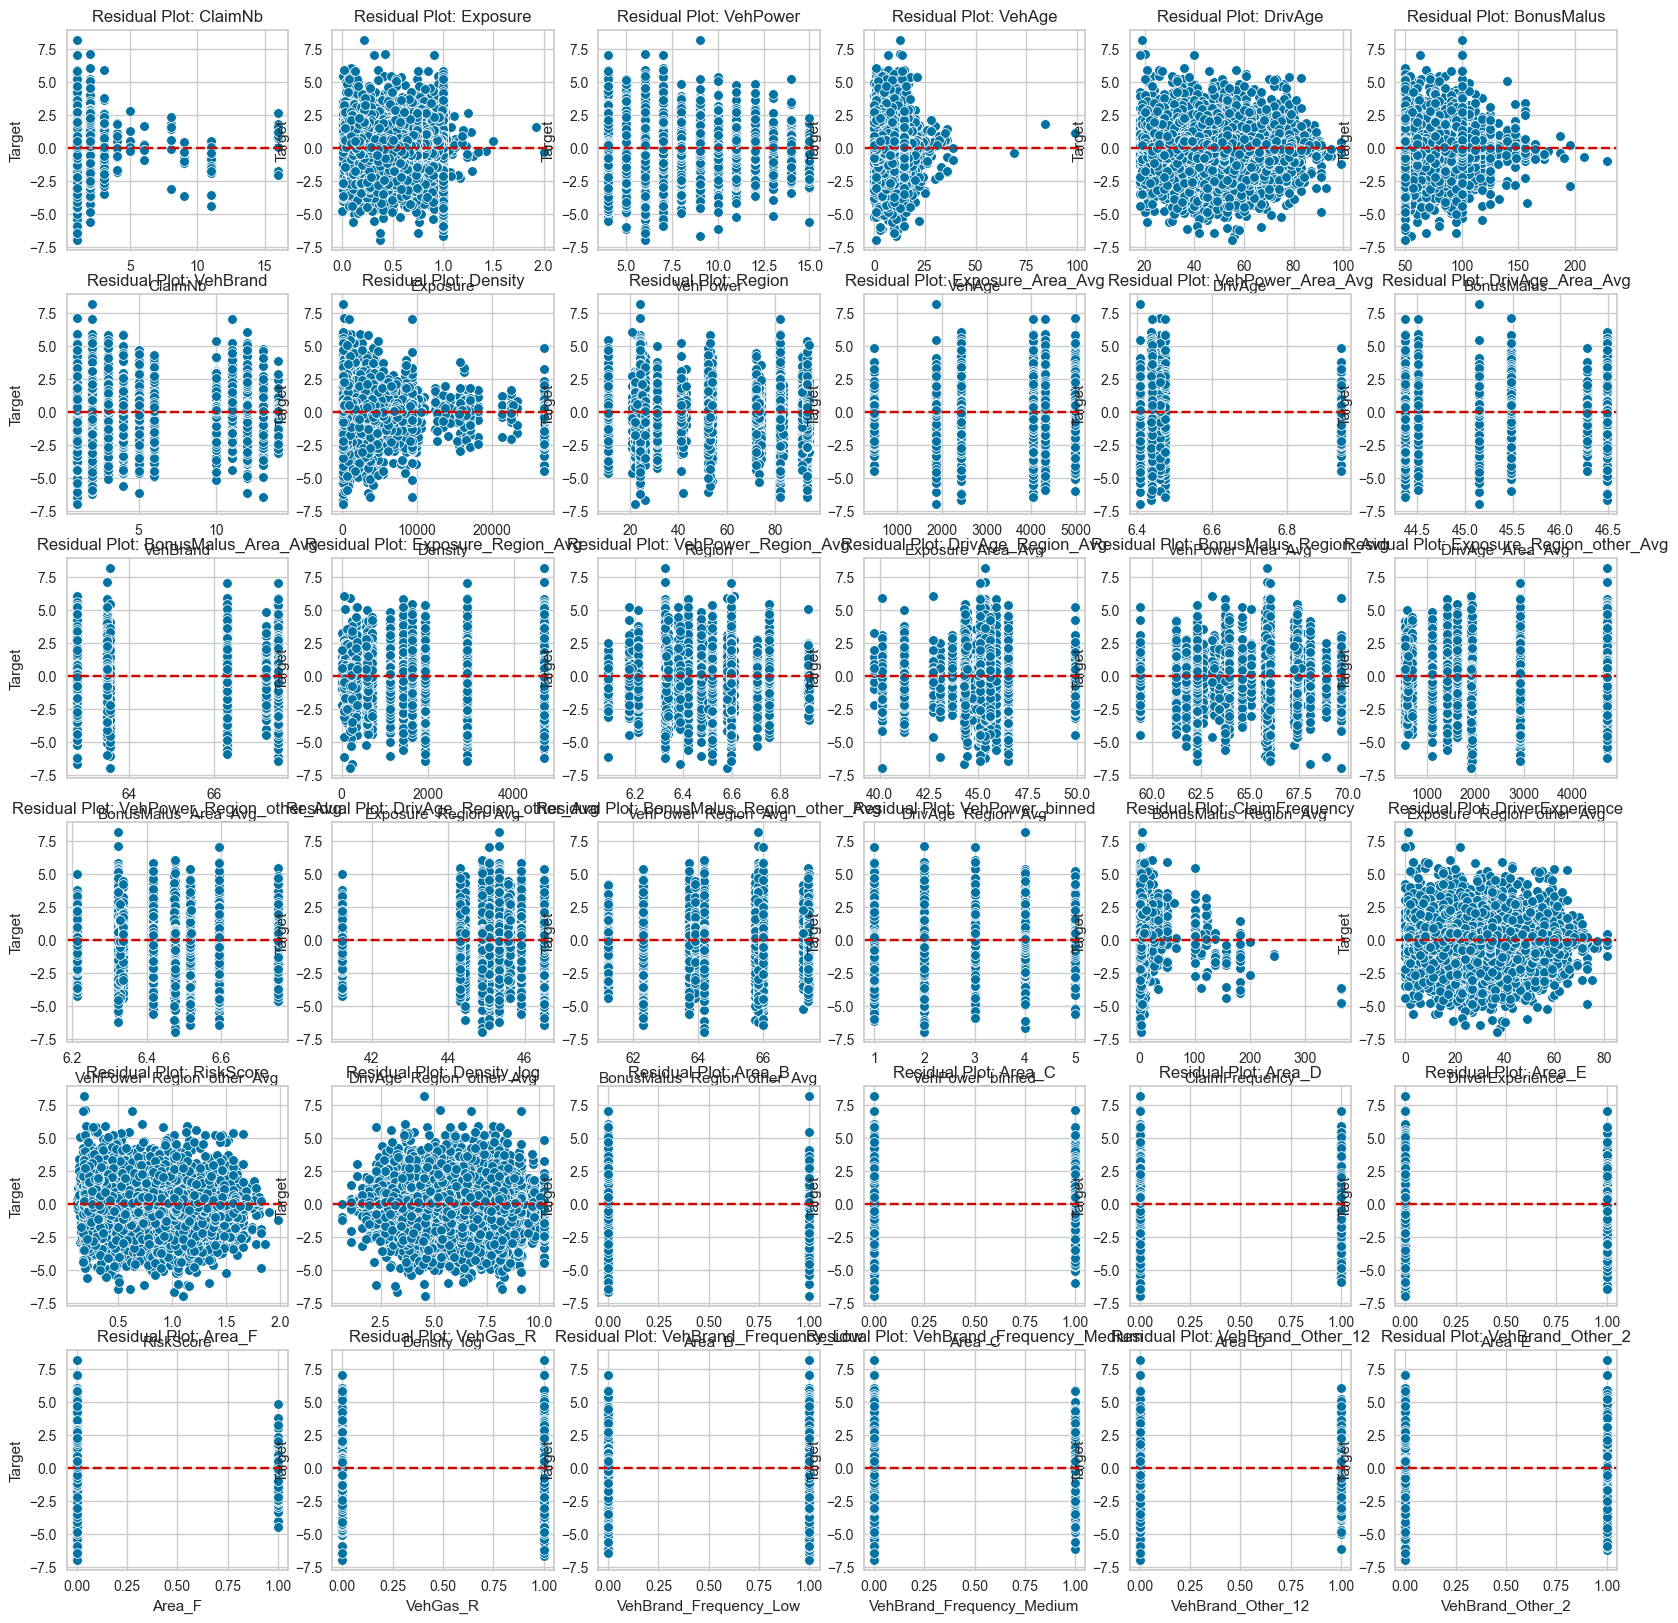

In [26]:

# One-hot encode categorical variables
data_features_encoded = pd.get_dummies(data_features, drop_first=True)

# Initialize the plot
fig, axes = plt.subplots(6, 6, figsize=(20, 20))
axes = axes.ravel()

# Iterate over columns and plot residuals
for i, col in enumerate(data_features_encoded.columns):
    X = data_features_encoded.copy()
    model = LinearRegression().fit(X, y_log)
    residuals = y_log - model.predict(X)
    
    sns.scatterplot(x=X[col], y=residuals, ax=axes[i])
    axes[i].set_title(f'Residual Plot: {col}')
    axes[i].axhline(y=0, color='r', linestyle='--')

plt.tight_layout()
plt.show()

1. **Non-Linearity:**

   - **ClaimNb:** The residuals for `ClaimNb` show a clear pattern, indicating that the relationship between `ClaimNb` and the target is not linear. This suggests that a linear model might not be the best choice for capturing the relationship between this feature and the target variable.
   - **BonusMalus:** Similarly, the residuals for `BonusMalus` show a curved pattern, which indicates non-linearity. This suggests that the linear model is not fully capturing the relationship between `BonusMalus` and the target.

2. **Heteroscedasticity:**

   - **Exposure:** The residuals for `Exposure` show a funnel shape, where the spread of residuals increases as the value of `Exposure` increases. This indicates heteroscedasticity, meaning that the variance of the residuals is not constant across all levels of `Exposure`.
   - **Density:** A similar issue of heteroscedasticity is seen with `Density`, where the residuals spread out more as density increases. This suggests that the variability of the target might change with density, which is not well captured by the linear model.

3. **Potential Multicollinearity:**

   - **VehAge and DrivAge:** The residuals for `VehAge` and `DrivAge` display a potential issue with multicollinearity. The patterns in these plots suggest that the variables might be correlated with each other or with other variables in the dataset, leading to instability in the model estimates.

### Tweedie Regression

Tweedie regression is chosen for its ability to model insurance claim data's unique distribution. The optimization process ensures might help me to find the best model configuration, while feature importance analysis provides insights into key predictors of claim amounts.

[I 2024-08-14 01:46:09,456] A new study created in memory with name: no-name-9b889f94-3df1-4bc6-81a8-f2b8cb0df3f8
[I 2024-08-14 01:46:09,663] Trial 0 finished with value: 1.1436355017268223 and parameters: {'power': 1.9899742604666675, 'alpha': 0.00014305012492746988, 'solver': 'newton-cholesky', 'k': 23}. Best is trial 0 with value: 1.1436355017268223.
[I 2024-08-14 01:46:09,871] Trial 1 finished with value: 1.1425549277510567 and parameters: {'power': 1.5504369462194614, 'alpha': 0.02751629421280132, 'solver': 'newton-cholesky', 'k': 25}. Best is trial 1 with value: 1.1425549277510567.
[I 2024-08-14 01:46:10,098] Trial 2 finished with value: 1.1424971457877247 and parameters: {'power': 1.5457383845432642, 'alpha': 0.00013407076002417513, 'solver': 'newton-cholesky', 'k': 60}. Best is trial 2 with value: 1.1424971457877247.
[I 2024-08-14 01:46:10,304] Trial 3 finished with value: 1.1428912282014634 and parameters: {'power': 1.6132597390098922, 'alpha': 0.03154435482261063, 'solver': '

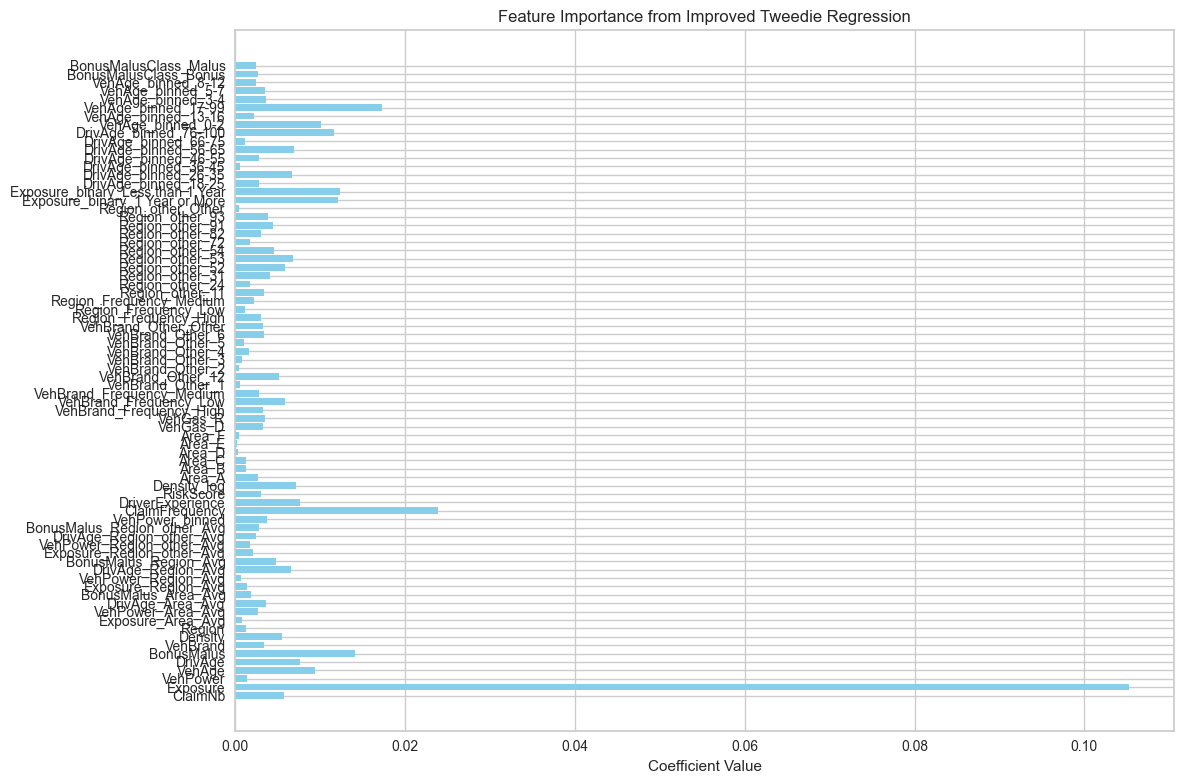

Best trial RMSE: 1.1410146991261436
Best parameters: {'power': 1.1034867461277706, 'alpha': 0.00029038596779098086, 'solver': 'lbfgs', 'k': 76}
Test RMSE: 1.1358744575132138
Test MAE: 0.7598496514690303
Test R-squared: 0.3569591106714759


In [28]:
selector = SelectKBest(score_func=f_regression, k='all')
pipeline = Pipeline([
    ('selector', selector),
    ('regressor', TweedieRegressor())
])

def objective(trial):
    # Suggest hyperparameters
    power = trial.suggest_float('power', 1.1, 2.0)
    alpha = trial.suggest_loguniform('alpha', 1e-4, 1e-1)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cholesky'])
    k = trial.suggest_int('k', max(1, int(0.1 * X_train_processed.shape[1])), X_train_processed.shape[1])
    
    # Update pipeline
    pipeline.set_params(
        selector__k=k,
        regressor__power=power,
        regressor__alpha=alpha,
        regressor__solver=solver,
        regressor__max_iter=1000
    )
    
    try:
        # Perform cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(pipeline, X_train_processed, y_train, cv=kf, scoring='neg_mean_squared_error')
        
        # Compute RMSE
        rmse = np.sqrt(-scores.mean())
        
        if np.isnan(rmse) or np.isinf(rmse):
            return float('inf')
        
        return rmse
    except Exception as e:
        print(f"Error in trial: {e}")
        return float('inf')

# Optimize hyperparameters with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Train final model with best parameters
best_params = study.best_params
pipeline.set_params(
    selector__k=best_params['k'],
    regressor__power=best_params['power'],
    regressor__alpha=best_params['alpha'],
    regressor__solver=best_params['solver']
)
pipeline.fit(X_train_processed, y_train)

# Make predictions on test set
y_pred = pipeline.predict(X_test_processed)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Feature importance visualization
selected_features = pipeline.named_steps['selector'].get_support()
selected_feature_names = X_train_processed.columns[selected_features]
feature_importances = np.abs(pipeline.named_steps['regressor'].coef_)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(selected_feature_names, feature_importances, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Feature Importance from Improved Tweedie Regression')
plt.tight_layout()
plt.show()

# Print results
print(f"Best trial RMSE: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")
print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")
print(f"Test R-squared: {r2}")

---
## Non-Linear Models


### Random Forest Regressor


The Random Forest Regressor is a powerful and versatile non-linear model capable of capturing complex relationships within the data. It operates by constructing an ensemble of decision trees during training and then averaging their predictions for regression tasks.

A key advantage of the Random Forest Regressor is its ability to effectively handle non-linear data, making it suitable for scenarios where traditional linear models fall short. Additionally, it is robust to multicollinearity, as it randomly selects subsets of features for each tree, reducing the reliance on any single predictor and enhancing model stability.

In [59]:
def train_random_forest_simple(X_train, X_test, y_train, y_test, data_type, run_name="Simple Random Forest"):
    with mlflow.start_run(run_name=run_name):
        try:
            mlflow.log_param("model_type", "Simple Random Forest")
            mlflow.log_param("data_preprocessing", data_type)

            # Define the model with fixed hyperparameters
            rf = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                min_samples_split=5,
                max_features=0.5,
                random_state=42,
                n_jobs=-1  # Use all available cores
            )

            # Fit the model
            rf.fit(X_train, y_train)

            # Make predictions
            y_pred = rf.predict(X_test)
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            # Log parameters and metrics
            mlflow.log_params({
                "n_estimators": rf.n_estimators,
                "max_depth": rf.max_depth,
                "min_samples_split": rf.min_samples_split,
                "max_features": rf.max_features
            })
            mlflow.log_metric("mse", mse)
            mlflow.log_metric("rmse", rmse)
            mlflow.log_metric("r2", r2)
            mlflow.sklearn.log_model(rf, "simple_random_forest_model")

            print("Simple Random Forest Results:")
            print(f"MSE: {mse}")
            print(f"RMSE: {rmse}")
            print(f"R Squared: {r2}")

            # Log feature importances
            feature_importances = rf.feature_importances_
            for feature, importance in zip(X.columns if hasattr(X, 'columns') else range(X.shape[1]), feature_importances):
                mlflow.log_metric(f"importance_{feature}", importance)
                print(f"{feature}: {importance}")

        except Exception as e:
            print(f"An error occurred: {str(e)}")
            mlflow.log_param("error", str(e))
            raise

    return rf, mse, rmse, r2

In [65]:
# Train and evaluate Random Forest

rf_model, mse, rmse, r2  = train_random_forest_simple(X_train_processed, X_test_processed, y_train, y_test, 'preprocessed_full')


TypeError: train_random_forest_simple() takes from 3 to 4 positional arguments but 5 were given

In [ ]:
best_model, mse, r2 = train_xgboost(X_train_processed, X_test_processed, y_train, y_test)

Training XGBoost model...
XGBoost Results:
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Mean Squared Error: 1.2375020928388525
R2 Score: 0.3771775352747204

Feature Importances:
0: 0.005009687505662441
1: 0.02225225791335106
2: 0.6569041609764099
3: 0.007492993958294392
4: 0.007314708083868027
5: 0.008040349930524826
6: 0.008706420660018921
7: 0.010720171965658665
8: 0.06391902267932892
9: 0.0
10: 0.011826746165752411
11: 0.01797291450202465
12: 0.0
13: 0.008738872595131397
14: 0.0
15: 0.0
16: 0.0
17: 0.0
18: 0.005079665686935186
19: 0.009922275319695473
20: 0.01101671066135168
21: 0.004201587755233049
22: 0.012149861082434654
23: 0.007614425849169493
24: 0.01140521839261055
25: 0.01791008748114109
26: 0.010445043444633484
27: 0.00761551083996892
28: 0.0
29: 0.011013912968337536
30: 0.02095215953886509
31: 0.017651792615652084
32: 0.014374915510416031
33: 0.005752004683017731
34: 0.0039965491741895676


# Automatic Model Selection

In this step, I will leverage PyCaret to automatically identify the best-performing model. I will conduct this search on both the processed and unprocessed datasets, ensuring that both have been merged and cleaned of duplicates.

In [30]:
data = pd.read_csv('../data/cleaned_data.csv')


data['IDpol'] = data['IDpol'].astype('int32')
data['Target'] = np.log(data['Target'])


# Initialize the setup
regression_setup = setup(data, target='Target', session_id=42, log_experiment=True, experiment_name='insurance_regression',
                         remove_outliers = True, feature_selection_method = 'sequential', transform_target = True)

,Description,Value
0,Session id,42
1,Target,Target
2,Target type,Regression
3,Original data shape,"(26209, 38)"
4,Transformed data shape,"(25291, 75)"
5,Transformed train set shape,"(17428, 75)"
6,Transformed test set shape,"(7863, 75)"
7,Numeric features,27
8,Categorical features,10
9,Preprocess,True


2024/08/14 01:55:19 INFO mlflow.tracking.fluent: Experiment with name 'insurance_regression' does not exist. Creating a new experiment.


In [31]:
#choose the best model
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.7448,1.2429,1.1145,0.3890,0.1475,0.1188,0.9970
lightgbm,Light Gradient Boosting Machine,0.7557,1.2643,1.1240,0.3786,0.1485,0.1202,0.4170
ridge,Ridge Regression,0.7681,1.2889,1.1349,0.3667,0.1491,0.1217,0.0940
lr,Linear Regression,0.7682,1.2890,1.1349,0.3666,0.1491,0.1217,0.5010
br,Bayesian Ridge,0.7675,1.2890,1.1350,0.3666,0.1491,0.1216,0.1120
rf,Random Forest Regressor,0.7984,1.3509,1.1620,0.3359,0.1527,0.1256,2.8650
ada,AdaBoost Regressor,0.8641,1.3810,1.1749,0.3210,0.1529,0.1323,0.6250
xgboost,Extreme Gradient Boosting,0.8264,1.4040,1.1845,0.3099,0.1550,0.1294,0.2250
et,Extra Trees Regressor,0.8409,1.4722,1.2131,0.2761,0.1588,0.1312,2.3740
en,Elastic Net,0.9074,1.7351,1.3167,0.1475,0.1670,0.1396,0.1090


2024/08/14 01:57:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 01:57:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 01:57:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 01:57:04 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 01:57:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 01:57:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

In [32]:
#finetune the best model
tuned_model = tune_model(best_model, early_stopping=10, return_train_score=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/08/14 01:58:22 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


In [33]:
if hasattr(best_model, 'get_params'):
    print(best_model.get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}


### Pycaret with unprocessed data

In [42]:
raw_data = pd.read_csv('../data/raw_data.csv')

raw_data.drop(columns=['ClaimAmount'], inplace=True)

raw_data['Target'] = np.log(raw_data['Target'])
regression_setup = setup(raw_data, target='Target', session_id=42, log_experiment=True, experiment_name='insurance_regression')

,Description,Value
0,Session id,42
1,Target,Target
2,Target type,Regression
3,Original data shape,"(26444, 13)"
4,Transformed data shape,"(26444, 49)"
5,Transformed train set shape,"(18510, 49)"
6,Transformed test set shape,"(7934, 49)"
7,Numeric features,8
8,Categorical features,4
9,Preprocess,True


In [43]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.7404,1.2360,1.1115,0.3953,0.1482,0.1195,0.4550
lightgbm,Light Gradient Boosting Machine,0.7502,1.2509,1.1182,0.3880,0.1488,0.1206,0.2120
rf,Random Forest Regressor,0.7874,1.3255,1.1511,0.3515,0.1525,0.1255,1.4420
xgboost,Extreme Gradient Boosting,0.7985,1.3392,1.1570,0.3447,0.1528,0.1267,0.0650
br,Bayesian Ridge,0.7922,1.3529,1.1627,0.3388,0.1522,0.1258,0.0270
lr,Linear Regression,0.7931,1.3531,1.1628,0.3387,0.1523,0.1260,0.3820
ridge,Ridge Regression,0.7930,1.3531,1.1628,0.3387,0.1523,0.1259,0.0200
ada,AdaBoost Regressor,0.8500,1.3637,1.1677,0.3321,0.1534,0.1321,0.2350
et,Extra Trees Regressor,0.8238,1.4367,1.1982,0.2975,0.1581,0.1303,1.1710
omp,Orthogonal Matching Pursuit,0.9828,2.0060,1.4159,0.0196,0.1782,0.1506,0.0220


2024/08/14 02:01:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 02:01:39 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 02:01:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 02:01:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 02:01:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/08/14 02:01:40 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when

In [44]:
tuned_model = tune_model(best_model, early_stopping=10, return_train_score=True)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


2024/08/14 02:02:42 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.


### Improving GBM model

In [ ]:
# Train the initial Gradient Boosting model
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0,
    max_features=None,
    random_state=42,
    criterion='friedman_mse',
    loss='squared_error',
    alpha=0.9,
    verbose=0
)
model.fit(X_train_processed, y_train)

# Baseline performance
y_pred = model.predict(X_test_processed)
baseline_r2 = r2_score(y_test, y_pred)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Baseline R-squared: {baseline_r2}")
print(f"Baseline RMSE: {baseline_rmse}")

# Get feature importances
features = X_train_processed.columns
importances = model.feature_importances_

# Store the best performing feature set
best_features = features.copy()
best_r2 = baseline_r2
best_rmse = baseline_rmse

while len(features) > 1:
    # Track if I successfully dropped a feature
    feature_dropped = False

    for feature in features:
        # Temporarily drop the feature
        X_train_reduced = X_train_processed.drop(columns=[feature])
        X_val_reduced = X_test_processed.drop(columns=[feature])

        # Retrain the model
        model = GradientBoostingRegressor()
        model.fit(X_train_reduced, y_train)

        # Evaluate the model
        y_pred = model.predict(X_val_reduced)
        current_r2 = r2_score(y_test, y_pred)
        current_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"Attempting to drop feature: {feature}")
        print(f"R-squared after dropping {feature}: {current_r2}")
        print(f"RMSE after dropping {feature}: {current_rmse}")

        if current_r2 >= best_r2 and current_rmse <= best_rmse:
            # If performance improves or remains the same, update the baseline and drop the feature
            best_r2 = current_r2
            best_rmse = current_rmse
            features = features.drop(feature)
            X_train_processed = X_train_reduced
            X_test_processed = X_val_reduced
            importances = model.feature_importances_
            feature_dropped = True
            print(f"Feature {feature} dropped.")
            break
        else:
            print(f"Feature {feature} retained due to performance drop.")

    if not feature_dropped:
        # If no feature was successfully dropped in this iteration, stop the process
        print("No further features can be dropped without reducing performance.")
        break

print("Backward elimination complete. Best features subset identified.")

Baseline R-squared: 0.3777301420984793
Baseline RMSE: 1.1173787846221306
Attempting to drop feature: Exposure
R-squared after dropping Exposure: 0.3595204724077423
RMSE after dropping Exposure: 1.1336099916193654
Feature Exposure retained due to performance drop.
Attempting to drop feature: VehPower
R-squared after dropping VehPower: 0.3777821712823821
RMSE after dropping VehPower: 1.1173320705471925
Feature VehPower dropped.
Attempting to drop feature: Exposure
R-squared after dropping Exposure: 0.35972269208916885
RMSE after dropping Exposure: 1.13343101919418
Feature Exposure retained due to performance drop.
Attempting to drop feature: VehAge
R-squared after dropping VehAge: 0.37703856917283085
RMSE after dropping VehAge: 1.1179995236164686
Feature VehAge retained due to performance drop.
Attempting to drop feature: DrivAge
R-squared after dropping DrivAge: 0.37801645266317185
RMSE after dropping DrivAge: 1.1171216982839127
Feature DrivAge dropped.
Attempting to drop feature: Expos

KeyboardInterrupt: 

---
## Neural Networks

In [50]:
# Create the model
model = Sequential([
    Dense(128, activation='elu', input_shape=(X_train_processed.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='elu'),
    Dropout(0.1),
    Dense(32, activation='elu'),
    Dropout(0.1),
    Dense(16, activation='elu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Define early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_processed, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test_processed, y_test, verbose=0)
print(f"Test MAE: {test_mae}")

# Make predictions
predictions = model.predict(X_test_processed)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"RMSE: {rmse}")

# Calculate R-squared
r2 = r2_score(y_test, predictions)
print(f"R-squared: {r2}")

Epoch 1/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step - loss: 7.5928 - mae: 1.8330 - val_loss: 1.3430 - val_mae: 0.7834
Epoch 2/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - loss: 1.6210 - mae: 0.9138 - val_loss: 1.3074 - val_mae: 0.7709
Epoch 3/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 1.5055 - mae: 0.8590 - val_loss: 1.3527 - val_mae: 0.8542
Epoch 4/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 1.4107 - mae: 0.8302 - val_loss: 1.2903 - val_mae: 0.7829
Epoch 5/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - loss: 1.4582 - mae: 0.8377 - val_loss: 1.2735 - val_mae: 0.7499
Epoch 6/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - loss: 1.4369 - mae: 0.8261 - val_loss: 1.2898 - val_mae: 0.8092
Epoch 7/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 1.3427 - mae: 0.8004 - val_loss: 1.3000 - val_mae: 0.7865
Epoch 8/100
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 1.4386 - mae: 0.8188 - val_loss: 1.2957 - val_mae: 0.7289
Epoch 9/100
525/525 ━━━━━━━━━━━━

# Discussion




The performance of the models so far has not been successful, but there are several additional steps that could be taken with more time:

**What Can Be Improved?**

- **Collect More Features:**
    - **Policyholder Demographics:** Gather data on gender, occupation, credit score, and other relevant demographic factors.
    - **Vehicle Characteristics:** For auto insurance, consider including details such as make, model, safety features, and maintenance history.
    - **Geographic Data:** Incorporate location-based risk factors like crime rates, weather patterns, and regional traffic conditions.
    - **Policy Details:** Add information on coverage limits, deductibles, and policy types.
    - **External Data:** Explore the use of economic indicators, local regulations, and other external factors that might influence risk.

- **Reframe the Problem as a Classification Task:**
    - Instead of predicting a continuous outcome, consider converting the problem into a classification task, such as predicting the likelihood of a claim exceeding a certain threshold.

- **Incorporate Domain Knowledge:**
    - Consult with insurance experts to integrate domain-specific insights into the model design, which could lead to more accurate and relevant feature engineering.

- **Advanced Modeling Techniques:**
    - Explore advanced modeling techniques such as ensembling and stacking models, which combine the strengths of multiple models to improve overall performance.